# Price Test

### Objective 

Pricing optimization is, non surprisingly, another area where data science can provide huge value.

In this excercise we have a hypothetical source of saas data.  Using this data, we want to conclude whether an increase in price will work for us, or if the test we're running shows something different.

The specific situation is such:
* Company XYZ sells a software for 39 dollars. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. 
* In the experiment, 66 percent of the users have seen the old price (39 dollars), while a random sample of 33 percent users a higher price (59 dollars).
* The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users. 
* Especially he asked you the following questions:
    * Should the company sell its software for 39 dollars or 59 dollars?
    * The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?
    * The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. 
        * Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.


So to repeat, the overall goal is to evaluate whether a pricing test running on the site has been successful.  We'll focus on user segmentation and will provide insights about segments that behave differently as well as any other insights we'll find.


<u>Data on our users includes:</u>
* user_id : the Id of the user. Can be joined to user_id in test_results table
* city : the city where the user is located. Comes from the user ip address
* country : in which country the city is located
* lat : city latitude - should match user city
* long : city longitude - should match user city

<u>Data on our test results includes:</u>
* user_id : the Id of the user. Can be joined to user_id in user_table
* timestamp : the date and time when the user hit for the first time company XYZ webpage. It is in user local time
* source : marketing channel that led to the user coming to the site. It can be:
    * ads-["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from google ads, yahoo ads, etc.
    * seo - ["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from google search, yahoo, facebook, etc.
    * friend_referral : user coming from a referral link of another user
    * direct_traffic: user coming by directly typing the address of the site on the browser
* device : user device. Can be mobile or web
* operative_system : user operative system. Can be: "windows", "linux", "mac" for web, and "android", "iOS" for mobile. Other if it is none of the above
* test: whether the user was in the test (i.e. 1 -> higher price) or in control (0 -> old/lower
price)
* price : the price the user sees. It should match test
* converted : whether the user converted (i.e. 1 -> bought the software) or not (0 -> left the site without buying it).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from datetime import datetime
import seaborn as sns
import scipy.stats as stats
import itertools
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2,f_classif
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.pipeline import Pipeline

# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV

from scipy.stats import skew, skewtest
import lifelines as sa
from lifelines.utils import concordance_index, k_fold_cross_validation

from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression, Perceptron
import datetime
# Importing Machine learning models library used for classification
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, BaggingClassifier,GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.naive_bayes import GaussianNB as GB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,roc_curve, auc
from sklearn import metrics, preprocessing
from sklearn.cross_validation import train_test_split
# import the class
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import f_regression,f_classif
from sklearn import metrics

import matplotlib.patheffects as path_effects
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree

# import tpot
%config InlineBackend.figure_format = 'png' 
%matplotlib inline
plt.style.use(style='fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 10)

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Users/bill_mac/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/bill_mac/.local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. T

In [2]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, \
                          labels = ['Left', 'Stayed']):
    
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, fontsize = 12)
    plt.yticks(tick_marks, labels, rotation = 90, fontsize = 12)
        
    plt.title(title, fontsize = 24)
    plt.ylabel('True', fontsize = 18)
    plt.xlabel('Predicted', fontsize = 18)
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in range(0,width):
        for y in range(0,height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, \
                                foreground='black'), path_effects.Normal()])
    return

def add_date_time_columns(dt): 
    
    # ADD THE DATE AND TIME IN SINGLE COLUMNS FOR GROUPPING THE CALLS BY HOURS
    dt1 = np.zeros((dt.shape[0], 4))

    for i in range(0,dt.shape[0]):
        s = dt.timestamp[i]
        s = s.split(' ')
        ymd = s[0]. split('-')
        hms = s[1]. split(':')
        dt1[i,0]=int(ymd[0])
        dt1[i,1]=int(ymd[1])
        dt1[i,2]=int(ymd[2])
        dt1[i,3]=int(hms[0])

    dt1 = pd.DataFrame(dt1)
    dt2 = pd.concat([dt,dt1], axis=1)

    names = dt2.columns.tolist()
    names[names.index(0)] = 'year'
    names[names.index(1)] = 'month'
    names[names.index(2)] = 'day'
    names[names.index(3)] = 'hour'
    dt2.columns = names
    dt2 = pd.DataFrame(dt2)
    
    return dt2

def fixdate(date):
    
    # check the last two characters - the number of seconds - and replace 60 with 59
    if str(date)[-2:] == '60':
        date = date[:-2]+'59'
    
    # check the characters that correspond to minutes and replace 60 with 59
    if str(date)[-5:-3] == '60':
        date = date[:-5]+'59'+date[-3:]
        
    return date

def model_building(dframe,X,y, pred_model):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    print("Building model %s" %pred_model)
    if pred_model == 'Random Forest':
        modl = RandomForestClassifier(class_weight={0:.981789881574,1:.82101184256})
    elif pred_model == 'SVM Linear':
        modl = SVC(kernel='linear')
    elif pred_model == 'SVM RBF':
        modl = SVC(kernel='rbf')
    elif pred_model == 'Logistic Regression':
        modl = LogisticRegression(class_weight={0:.981789881574,1:.82101184256})
    elif pred_model == 'kNN':
        ref_score = -99
        nbr_neighbors = -9
        for k in range(2,10):
            print("In loop for %s neighbors" %k)
            modl = KNeighborsClassifier(n_neighbors=k)
            modl.fit(X_train, y_train)
            modl.predict(X_test)
            if modl.score(X_test, y_test) > ref_score:
                ref_score = modl.score(X_test, y_test)
                nbr_neighbors = k

        modl = KNeighborsClassifier(n_neighbors=nbr_neighbors)
        print("%s is the optimal number of neighbors" %nbr_neighbors)

    modl.fit(X_train, y_train)
    y_pred = modl.predict(X_test) 

    if pred_model == 'Random Forest':
        labels = list(dframe.columns.values)
        labels.remove('converted')
        feat_importance = pd.DataFrame(modl.feature_importances_, columns=['values'])
        feat_importance['index'] = labels
        feat_importance = feat_importance.set_index('index')
        feat_importance = feat_importance.sort_values(['values'], ascending=False)
        print("Features importance: %s" %feat_importance)

    print("Accuracy for %s = %s" %(pred_model, round(100.*modl.score(X_test, y_test), 2)))
    print confusion_matrix(y_test, y_pred)
    
    ####
    logit = y_pred
    y_pred_prob = modl.predict_proba(X_test)[:, 1]
    plt.hist(y_pred_prob, bins=5)
    plt.xlim(0, 1)
    plt.title('Histogram of Predicted Probabilities')
    plt.xlabel('Predicted Probability of Conversion')
    plt.ylabel('Frequency')
    cm = confusion_matrix(y_test, logit)


    plot_confusion_matrix(cm, title='Model: Confusion Matrix', \
                          labels=['Not Converted', 'Converted'], cmap=plt.cm.Greens) 
    # Roc_curve for Logistic Regression Model
    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    # For class 1, find the area under the curve
    FPR[1], TPR[1], _ = roc_curve(y_test, logit)
    ROC_AUC[1] = auc(FPR[1], TPR[1])

    # Plot of a ROC curve for class 1
    plt.figure(figsize=[5,5])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0, 1])
    plt.ylim([0, 1.5])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title('Model Receiver operating characteristic for Conversion', fontsize=18)
    plt.legend(loc="upper left")
    plt.show()
    

### Load Data

In [3]:
df_results = pd.read_csv('../data/test_results.csv')
df_user = pd.read_csv('../data/user_table.csv')

In [4]:
# let's check if we have one row per user in both tables
print len(set(df_user['user_id'])), len(df_user) # this compares how many unique users we have to how many rows in the table
print len(set(df_results['user_id'])), len(df_results)

275616 275616
316800 316800


There are almost 40k more result table rows than user table rows. That's kind of a lot, so we might not want to just inner join and throw those 40k away.  Let's check it out.

In [5]:
# let's join the two tables together, and call this our leftdf data table
leftdf = df_results.merge(df_user, how = 'left', left_on ='user_id', right_on='user_id')


In [6]:
for col in leftdf:
    print col, leftdf[col].isnull().sum()*1.0/len(leftdf)

user_id 0.0
timestamp 0.0
source 0.0
device 0.0
operative_system 0.0
test 0.0
price 0.0
converted 0.0
city 0.13
country 0.13
lat 0.13
long 0.13


Cool, so only 13% of any column in our results data is null. Since we have a few hundred thousand rows, it's probably fine to drop these users, but first we should see if we can find any differences in their traits that may bias our results. Just to double check.

So let's make some crosstabs and compare our user groups (those with geo data and those without).

In [7]:
leftdf['geo_bool'] = leftdf['country'].isnull() == False

In [8]:
geo_conv = pd.crosstab(leftdf['geo_bool'],leftdf['converted'])
geo_conv['convprc'] = geo_conv[1]/(1.0*geo_conv[0]+geo_conv[1])
geo_conv

converted,0,1,convprc
hasgeo,,,
False,40395,789,0.019158
True,270597,5019,0.018210


conversion is a little below 2% for both groups

In [9]:
# Let's test for independence of these two variables using a chi-squared test
from scipy.stats import chi2_contingency
chi2_contingency((pd.crosstab(leftdf['geo_bool'],leftdf['converted'])), correction=False)[1]  

0.18111246507651174

Great so the p-value signals that users with or without geographic information convert at the same rate between test and control.  

The p-value is not significant and we can conclude that users with or without geographic information do not bias the results.

So let's just take them out like we were planning to

### Preprocess Data

In [10]:
df = df_results.merge(df_user, left_on='user_id', right_on='user_id', how='inner')
df_all = add_date_time_columns(df)
df_all = df_all.sort_values(by=['timestamp', 'price'], ascending=[1, 1])

In [11]:
# df_all['day_of_week'] = datetime.date(df_all.year, df_all.month, df_all.day).weekday()
# apply the function to change the date field
df_all['date_2'] = df_all['timestamp'].map(fixdate)


In [12]:
from dateutil.parser import parse
# re-cast timestamp column as a date object
df_all['date_2'] = df_all['date_2'].map(lambda x: parse(str(x)))

# grab just the day so we can look at users by day without worrying about time
df_all['day_num_of_week'] = df_all['date_2'].map(lambda x: x.date())

In [13]:
df_all['day_of_week'] = df_all['date_2'].map(lambda x: x.strftime("%A"))

In [14]:
df_all.head(3)

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,year,month,day,hour,date_2,day_num_of_week,day_of_week
144512,503836,2015-03-02 00:04:12,ads-google,web,windows,1,59,0,Plymouth,USA,45.02,-93.46,2015.0,3.0,2.0,0.0,2015-03-02 00:04:12,2015-03-02,Monday
17593,583796,2015-03-02 00:12:40,ads_facebook,web,windows,0,39,0,Jacksonville,USA,30.33,-81.66,2015.0,3.0,2.0,0.0,2015-03-02 00:12:40,2015-03-02,Monday
242435,632922,2015-03-02 00:16:25,ads-google,web,windows,0,39,0,Virginia Beach,USA,36.74,-76.04,2015.0,3.0,2.0,0.0,2015-03-02 00:16:25,2015-03-02,Monday


Let's visualize the first 500 users and their location 

In [15]:
import folium
from folium import plugins

users_map = folium.Map(location=[df_all['lat'].mean(), df_all['long'].mean()], zoom_start=4)
marker_cluster = folium.MarkerCluster().add_to(users_map)
for name, row in df_all[:500].iterrows():
    folium.Marker([row["lat"], row["long"]], popup="{0}: {1}".format(row["user_id"], row["city"])).add_to(marker_cluster)
users_map.save('users.html')
users_map

In [70]:
print "Rows: %r, Columns: %r "%(df.shape[0],df.shape[1])
print list(set(df.columns))

Rows: 275616, Columns: 12 
['city', 'user_id', 'source', 'timestamp', 'price', 'long', 'test', 'converted', 'operative_system', 'country', 'device', 'lat']


In [17]:
df_all.describe()

,user_id,test,price,converted,lat,long,year,month,day,hour
count,275616.000000,275616.000000,275616.000000,275616.000000,275616.000000,275616.000000,275616.0,275616.000000,275616.000000,275616.000000
mean,499245.801521,0.359878,46.201324,0.018210,37.111680,-93.981772,2015.0,4.042164,15.878523,11.885689
std,288533.458944,0.479965,9.600403,0.133711,5.209627,18.086486,0.0,0.822336,8.776944,5.055906
min,3.000000,0.000000,39.000000,0.000000,19.700000,-157.800000,2015.0,3.000000,1.000000,0.000000
25%,249544.500000,0.000000,39.000000,0.000000,33.660000,-112.200000,2015.0,3.000000,8.000000,9.000000
50%,498861.000000,0.000000,39.000000,0.000000,37.740000,-88.930000,2015.0,4.000000,16.000000,12.000000
75%,748856.500000,1.000000,59.000000,0.000000,40.700000,-78.910000,2015.0,5.000000,23.000000,15.000000
max,999999.000000,1.000000,59.000000,1.000000,61.180000,30.310000,2015.0,5.000000,31.000000,23.000000


In [19]:
categorical_vars = ['country','source','device','operative_system']

In [20]:
def plot_variables(variable_list = categorical_vars, file_location='../figures/categorical_vars.png'):
    for i,j in itertools.izip_longest(variable_list,range(len(variable_list))): # itertools.zip_longest for to execute the longest loop
        plt.subplot(np.ceil(len(variable_list)/2),2,j+1)
        plt.subplots_adjust(hspace=.5)
        sns.countplot(x=i,data = df)
        plt.xticks(rotation=90)
        plt.title(str("No. of Users by "+i.title()))
        # Get current axis on current figure
        ax = plt.gca()

        # Iterate through the list of axes' patches
        for p in ax.patches:
            ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
                    fontsize=12, color='black', ha='center', va='bottom')
    plt.savefig(file_location)

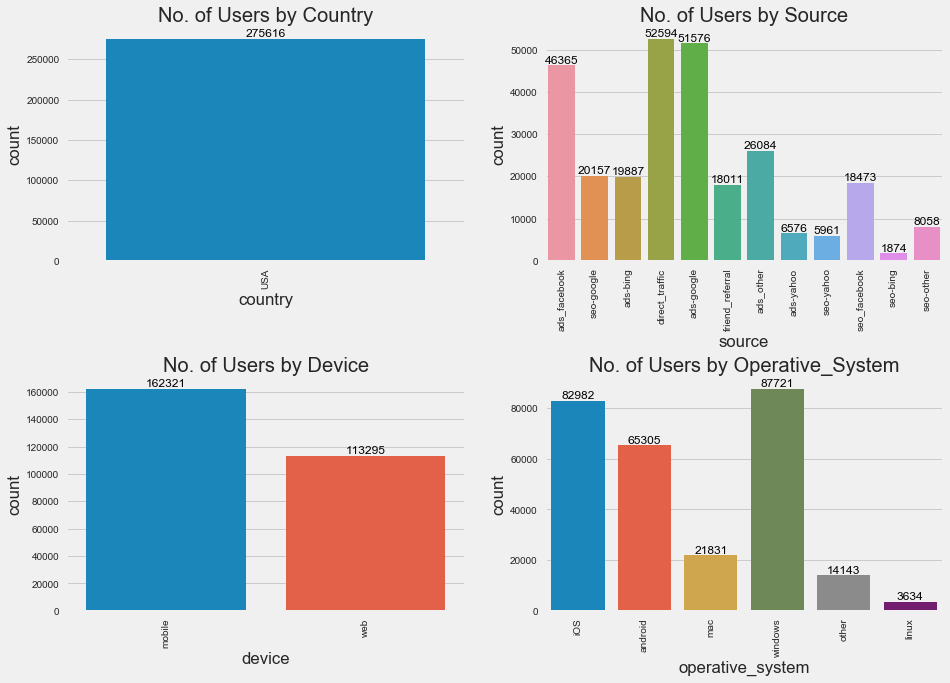

In [21]:
plot_variables(variable_list = categorical_vars, file_location='../figures/categorical_vars.png')

Notes:
  * We've got a US based site in which about 60% come from mobile devices.
  * But out of those mobile users, ios user make up almost half
  * Out of desktop users, windows dominate.  Interesting.
  * The top three channels users are reached by are 1) direct traffic, 2) ads from google, and 3) ads from facebook.

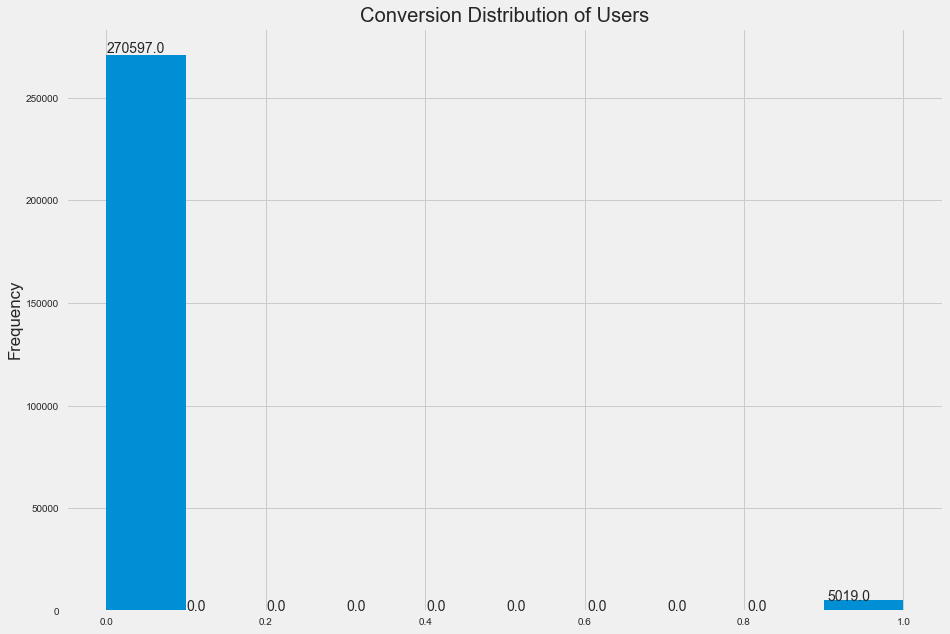

In [23]:
ax = df.converted.plot(kind = 'hist', title = 'Conversion Distribution of Users')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/conversion_distribution_of_users.png')

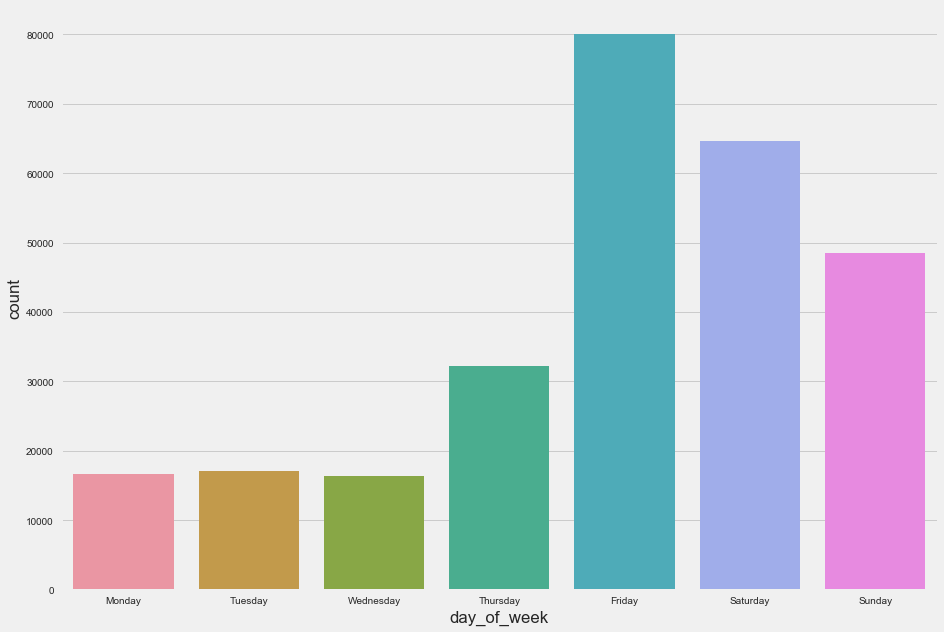

In [24]:
# main['just_date'].value_counts().sort_index(ascending=True).plot(figsize=(15,10),title='Users per Day')
# plt.show()
sns.countplot(x='day_of_week',data = df_all)

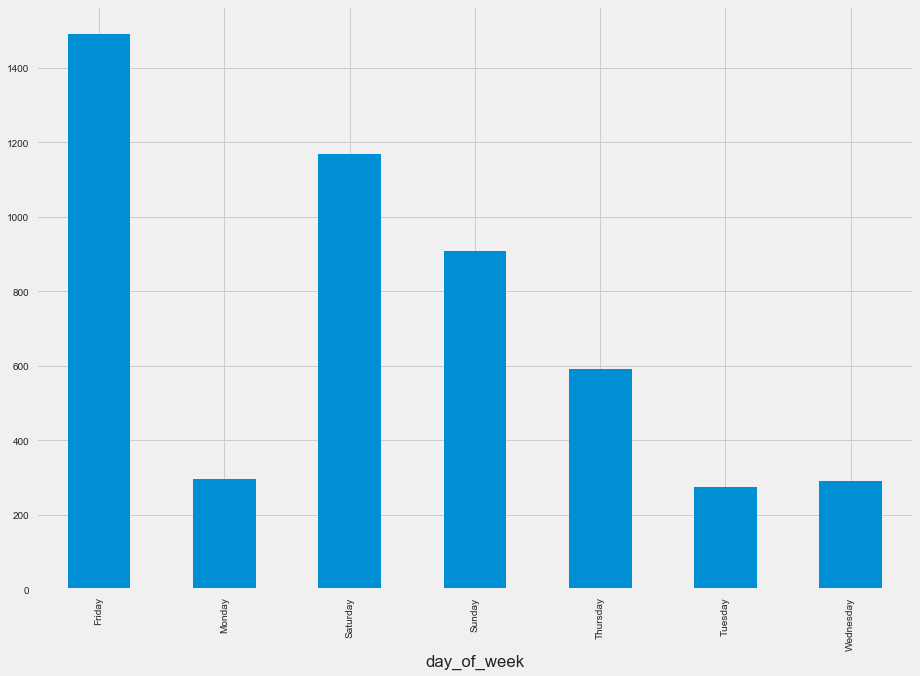

In [25]:
df_all.groupby('day_of_week')['converted'].sum().plot(kind='bar')

From this plot it really looks like we've got ourselves a very unbalanced set, but we should still be able to discern a lot about what works and what doesn't for converting users

### Top 10 Cities by Conversion Rate

In [27]:
df_all.groupby('city').mean()['converted'].sort_values(ascending = False).head(10).reset_index().values[0][0]
# df.columns
df_all[df_all.city == df_all.groupby('city').mean()['converted'].sort_values(ascending = False).head(10).reset_index().values[0][0]]['lat']

122208    33.86
74457     33.86
249954    33.86
173656    33.86
21904     33.86
Name: lat, dtype: float64

In [28]:
df_all.groupby('city').mean()['converted'].sort_values(ascending = False).head(10).reset_index().city

0                     North Atlanta
1                       Catonsville
2                     Saint Charles
3          Parkway-South Sacramento
4                           Findlay
5                      Blue Springs
6                    Bonita Springs
7                      Lehigh Acres
8    Parsippany-Troy Hills Township
9                          Sun City
Name: city, dtype: object

In [29]:
top_cities_map = folium.Map(location=[df_all[df_all.city == df_all.groupby('city').mean()['converted'].sort_values(ascending = False).head(10).reset_index().values[0][0]]['lat'].mean()
                                      , df_all[df_all.city == df_all.groupby('city').mean()['converted'].sort_values(ascending = False).head(10).reset_index().values[0][0]]['long'].mean()], zoom_start=4)
marker_cluster = folium.MarkerCluster().add_to(top_cities_map)
for name, row in df_all[df_all.city.isin(list(df_all.groupby('city').mean()['converted'].sort_values(ascending = False).head(10).reset_index().city))].iterrows():
    folium.Marker([row["lat"], row["long"]], popup="{0}: {1}".format(row["user_id"], row["city"])).add_to(marker_cluster)
top_cities_map.save('../figures/top_cities.html')
top_cities_map

In [30]:
categorical_vars = ['source','device','operative_system','month', 'day','hour','price','day_of_week']

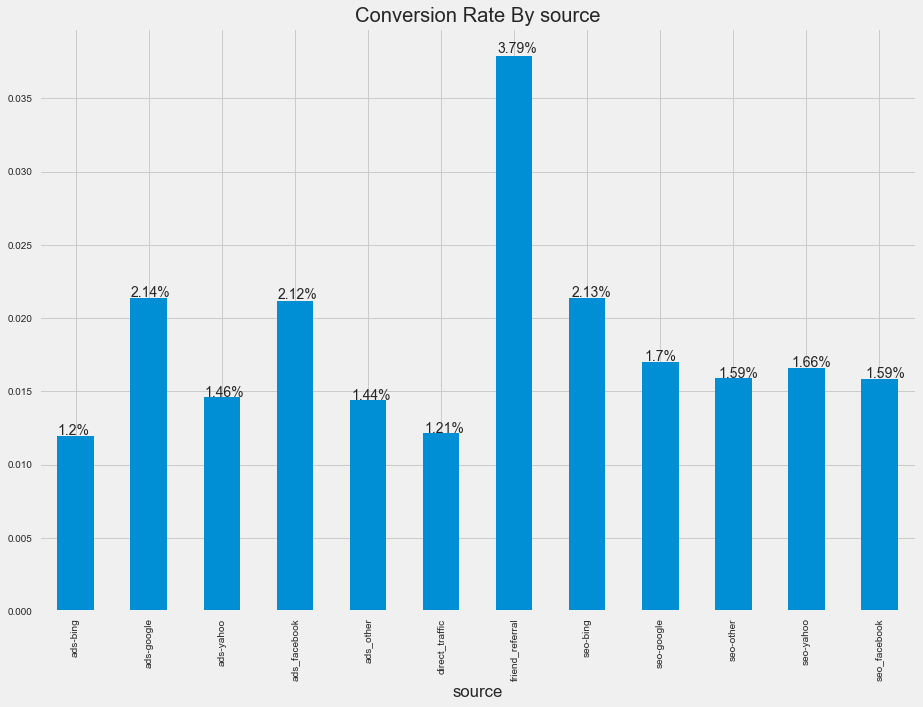

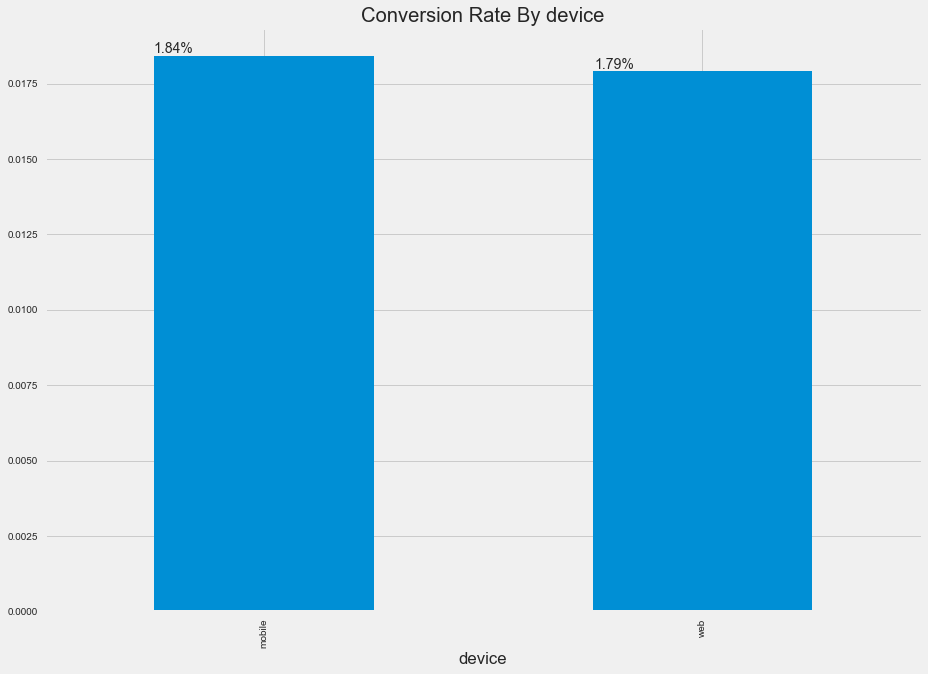

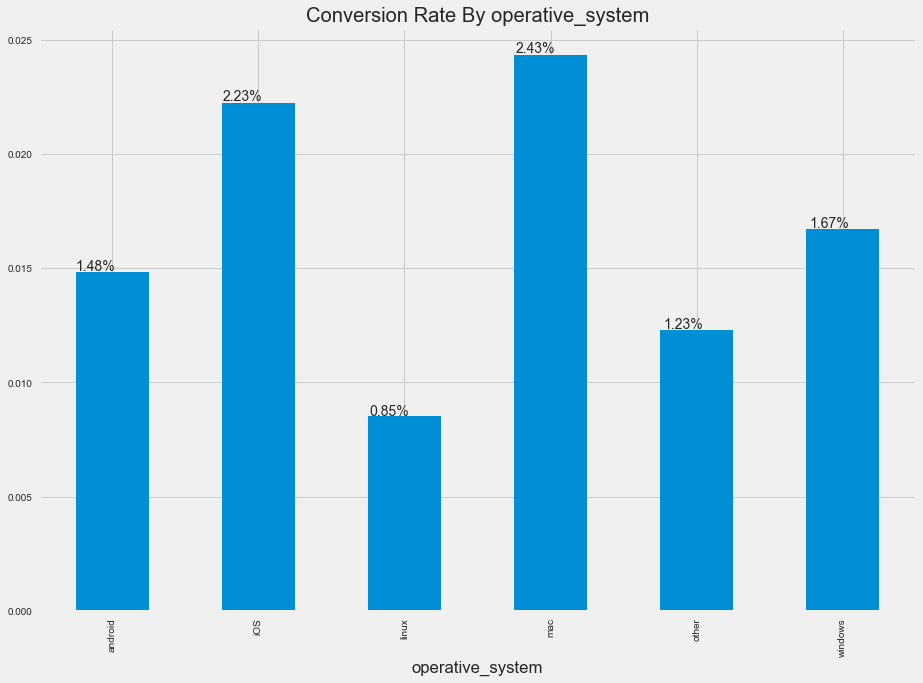

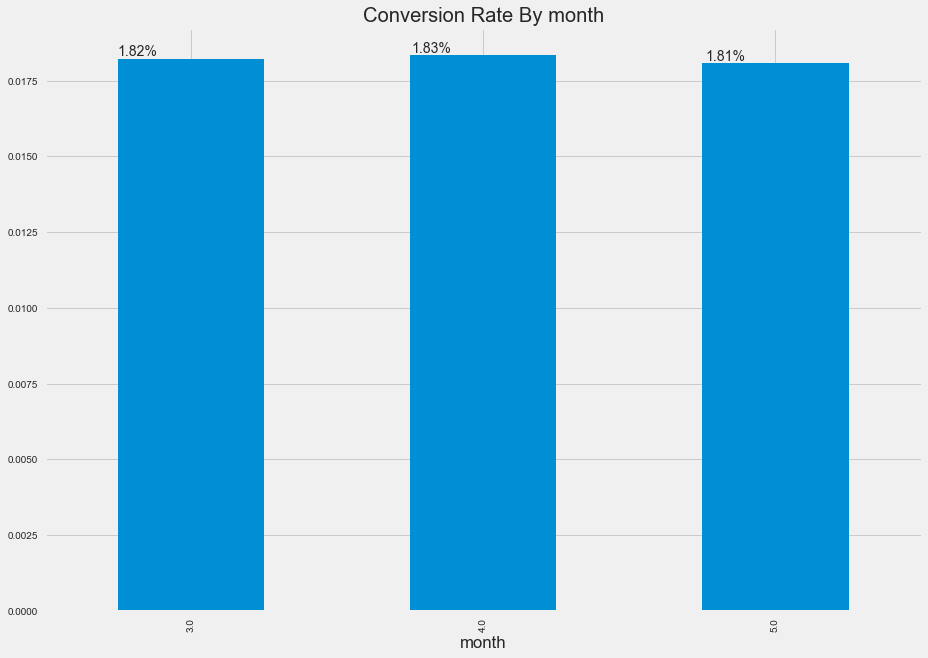

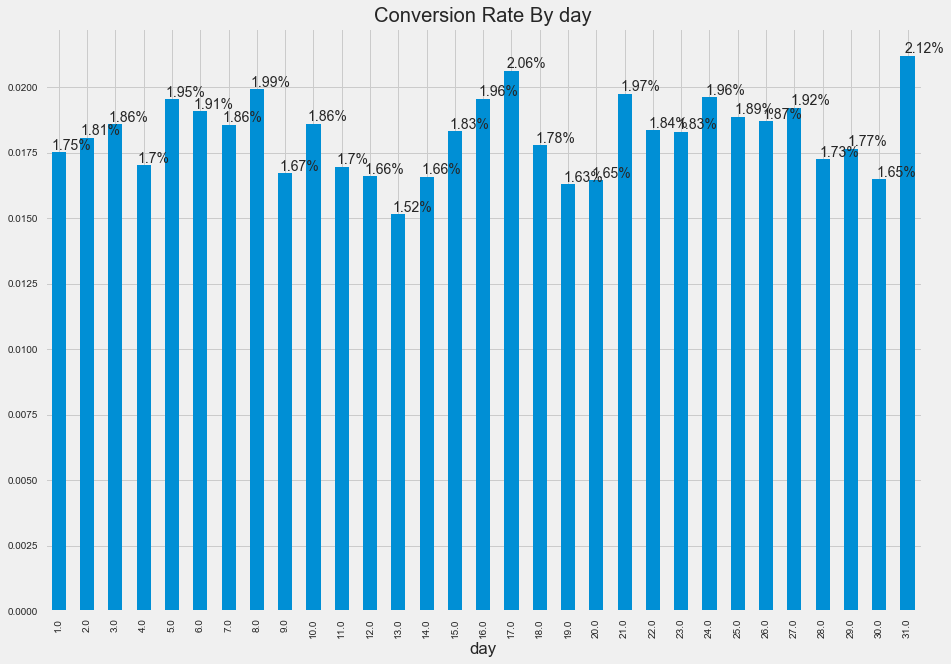

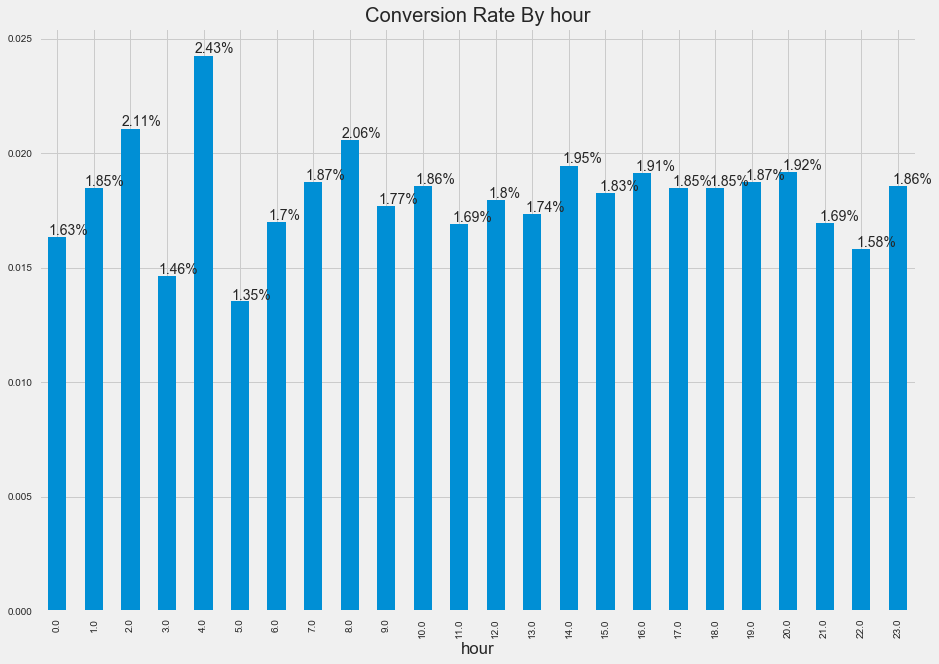

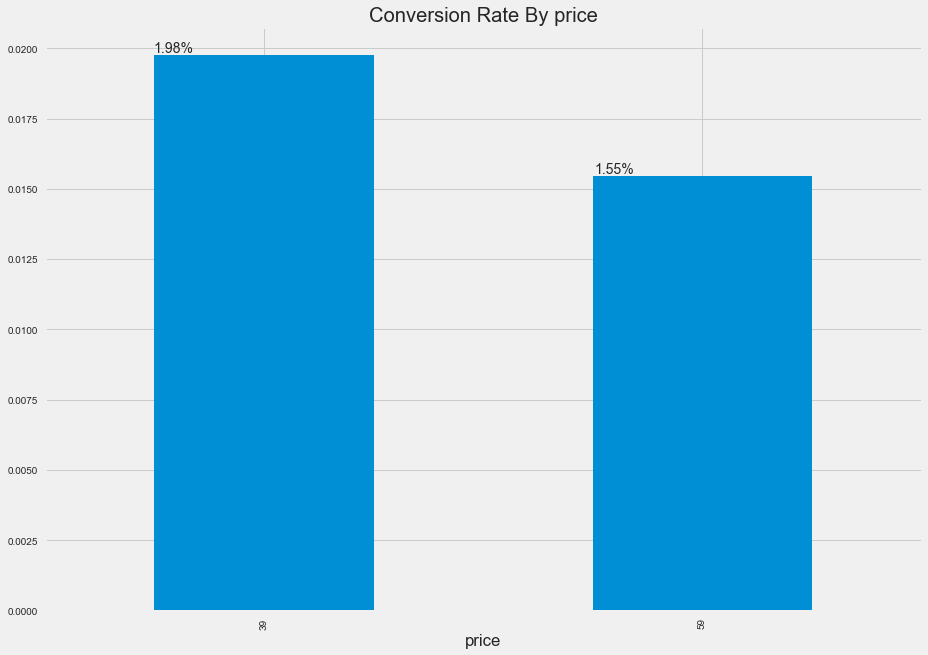

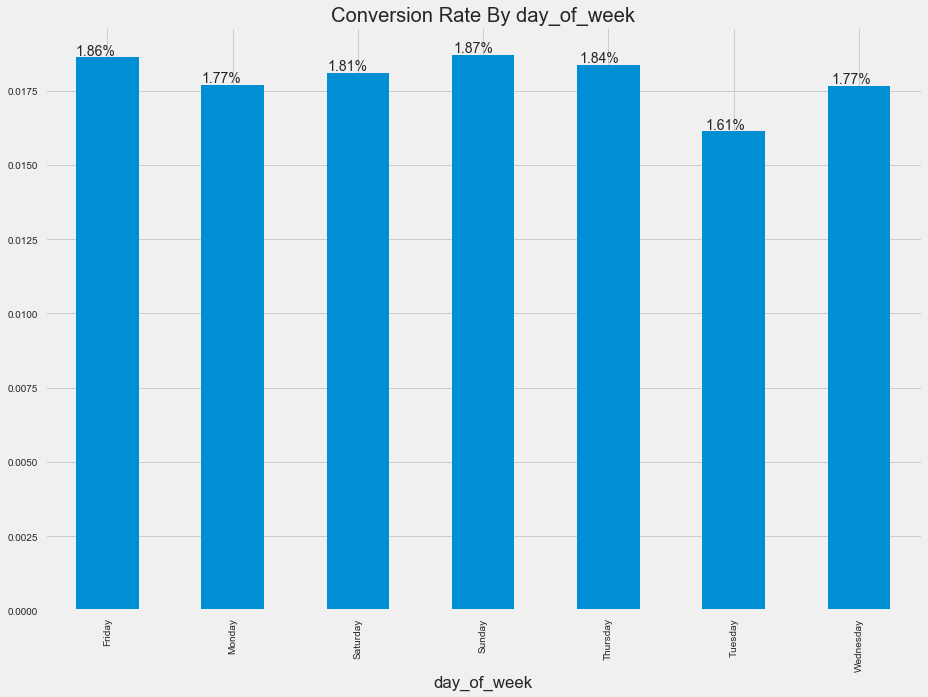

In [31]:
for var in categorical_vars:
    ax = df_all.groupby(var).mean()['converted'].plot(kind='bar',title = 'Conversion Rate By '+str(var))
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height()*100,2))+"%", (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()
    plt.savefig('../figures/conversion_rate_by_'+var+'.png')

Notes:
  * Couple things here, our top channel in users is the 2nd worst at converting. I would tell the VP of product that we need to focus some of our efforts here in order to improve that rate.
  * Friend_referral blows the competition out of the water in terms of conversion rate, despite being in the middle of the pack in user volume. I would also look to focus efforts on getting more users from the friend_referral channel.
  * In terms of operating systems, android needs to do improve, but more importantly windows conversion rate needs to improve.  It has the highest desktop userbase yet is below mac users in conversion rate
  * We have to do a better job of converting users on Friday as it has the most user volume but average conversion rate
  * Overall we see a huge increase in traffic on weekends

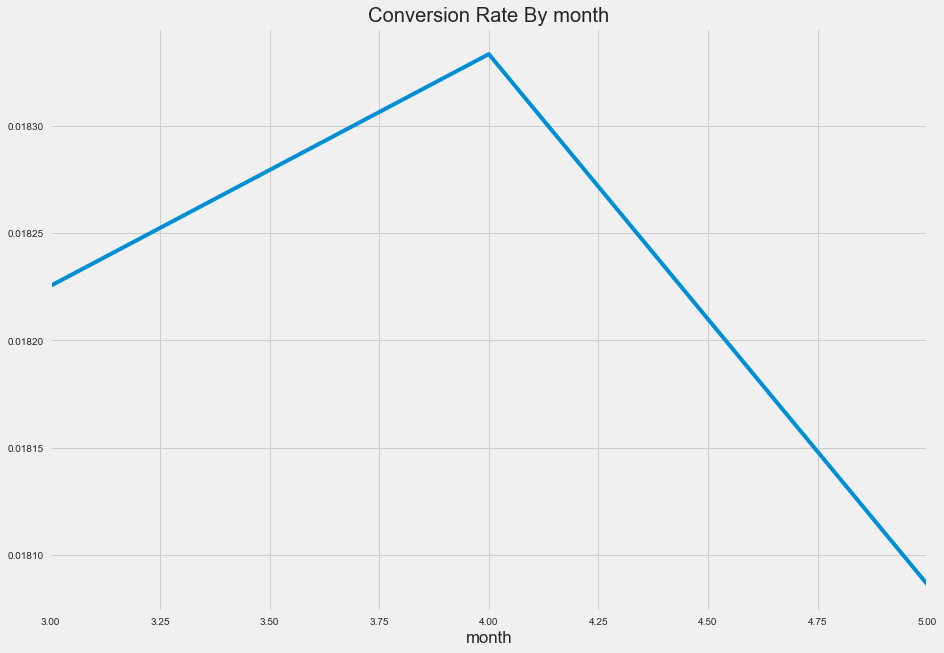

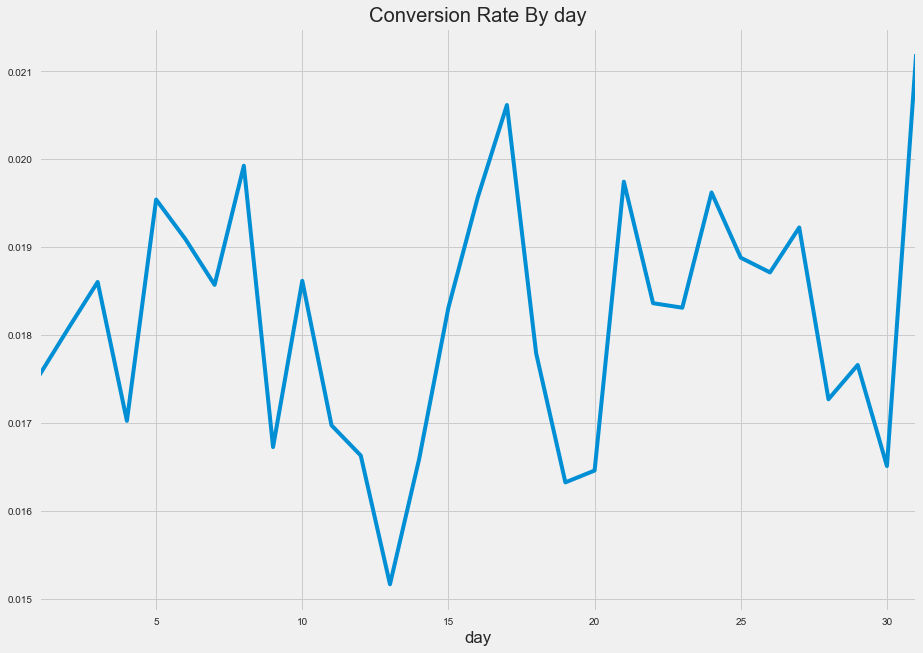

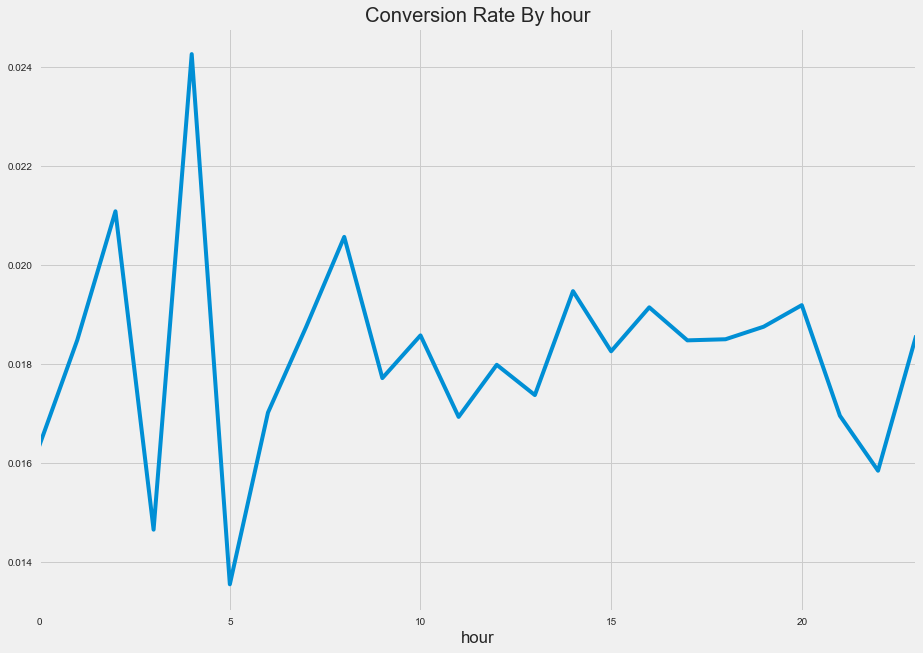

In [32]:
# for var in df[df.columns.difference(categorical_vars)]:
for var in df_all[['month','day','hour']]:
    ax = df_all.groupby(var).mean()['converted'].plot(kind='line',title = 'Conversion Rate By '+str(var))
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height()*100,2))+"%", (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()
    plt.savefig('../figures/time_distribution_of_users.png')

Let's combine sources into a new feature - see what it looks like

In [33]:
# import regex package to do a fancy split
import re

# define secondary source column as the first element when the source column is split on either - or _
df_all['source_2'] = df_all['source'].map(lambda x: re.split(pattern='[_-]',string=x)[0])

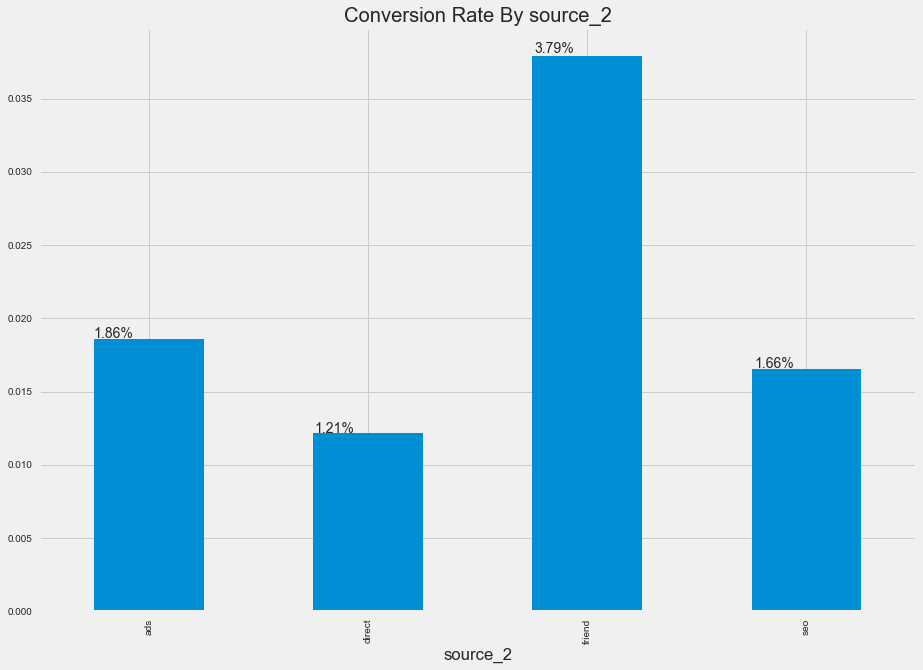

In [34]:
for var in ['source_2']:
    ax = df_all.groupby(var).mean()['converted'].plot(kind='bar',title = 'Conversion Rate By '+str(var))
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height()*100,2))+"%", (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()
    plt.savefig('../figures/conversion_rate_by_'+var+'.png')

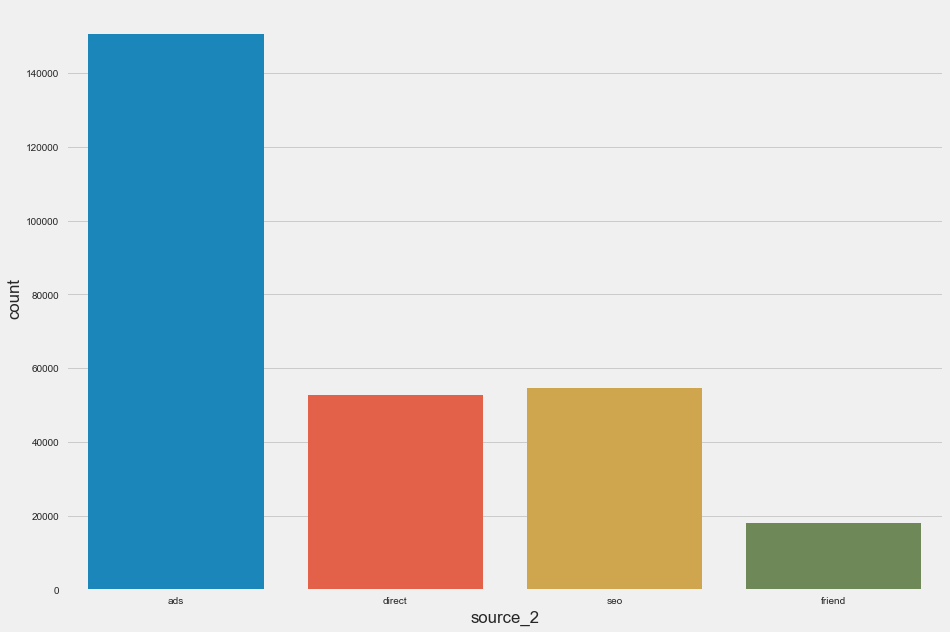

In [35]:
sns.countplot(x='source_2',data=df_all)

# Should the price be 39 dollars or higher at 59 dollars?

Okay so let's look and see if it's a good idea to go with 50 dolalrs and maximize our revenue. 

One approach to this question - Since we have different splits for our customers in the price categories, we'll take the revenue per customer metric to see what's the better option.  We could also run a regression to determine the elasticity of price and use that to make a recommendation about pricing strategy as well. We'll see.


In [36]:
# create crosstab of user conversion by test grouping
revenue_simple = pd.crosstab(df_all['test'],df_all['converted'])

# calculate revenue as sales*price, scaling the test group's price up by (59/39)
revenue_simple['rev'] = revenue_simple[1]*39.0
revenue_simple['rev'][1] = revenue_simple['rev'][1]*(59.0/39.0)

# calculate revenue per customer
revenue_simple['rev_per_cust'] = revenue_simple['rev']/(1.0*revenue_simple[0]+revenue_simple[1])

# show it
revenue_simple

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


converted,0,1,rev,rev_per_cust
test,,,,
0,172939,3489,136071.0,0.771255
1,97658,1530,90270.0,0.910090


By this logic above, it seems as though the revenue per customer at 40 dollars is .77 while it's .91 in the test group that saw the 59 dollar price.  So for the same number of customers, the revenue per person would be higher in the test group with the higher dollar price.

In other words, the expected Revenue is 0.93 when the price is 59 dollars and 0.79 when the price is 39 dollars.


If we wanted to we could run a regression the predict converts as a function of price and then use the coefficient as the elasticity of demand.  This is possible and we may revisit it later.

So what can we do, and what do we know? If we assume that lower prices will result in more sales and higher gross revenue but lower per unit `rev_per_cust` could postentially result in lower profit.

profit = revenue - cost

We can also assume that higher prices will result in less sales and less overall gross revenue but higher per unit revenue and potentially higher profit.

Let's figure out a demand metric, like sales per n customers, and we'll apply to see which price to go with.



In [37]:
# create number of sales per 100 customers for both pricing schemes
revenue_simple['sales_per_kcust'] = revenue_simple[1]*1.0/((revenue_simple[0]+revenue_simple[1])*1.0/100)
revenue_simple

converted,0,1,rev,rev_per_cust,sales_per_kcust
test,,,,,
0,172939,3489,136071.0,0.771255,1.977577
1,97658,1530,90270.0,0.910090,1.542525


In [72]:
revenue_simple['Conversion_Rate']=revenue_simple[True]/revenue_simple[False]

In [74]:
revenue_simple['Price']=[39,59]

converted,0,1,rev,rev_per_cust,sales_per_kcust,Conversion_Rate,Price
test,,,,,,,
0,172939,3489,136071.0,0.771255,1.977577,0.020175,39
1,97658,1530,90270.0,0.910090,1.542525,0.015667,59


In [76]:
revenue_simple['expected_rev'] = revenue_simple.Conversion_Rate*revenue_simple.Price

In [77]:
revenue_simple

converted,0,1,rev,rev_per_cust,sales_per_kcust,Conversion_Rate,Price,expected_rev
test,,,,,,,,
0,172939,3489,136071.0,0.771255,1.977577,0.020175,39,0.786815
1,97658,1530,90270.0,0.910090,1.542525,0.015667,59,0.924348


In [114]:
revenue_simple['users'] = revenue_simple[0]+revenue_simple[1]

we are going to perform a t-test to test whether the test group's average revenue is higher than control group's average revenue

H0: test group's average revenue equal to control group's average revenue

HA: test group's average revenue is higher than control group's average revenue

In [115]:
revenue_simple[['Conversion_Rate','rev_per_cust','users']]

converted,Conversion_Rate,rev_per_cust,users
test,,,
0,0.020175,0.771255,176428
1,0.015667,0.910090,99188


In [121]:
revenues = df_all.groupby(by="test").apply(lambda df: df.price * df.converted)
ctrl_revenues = revenues[0]
test_revenues = revenues[1]

In [117]:
import scipy.stats

In [124]:

ttest_result = scipy.stats.ttest_ind(test_revenues,ctrl_revenues,equal_var=False)
# ttest_ind is a two tailed
# our HA is test_mean > ctrl_mean, so we need to divide by 2
ttest_result.pvalue/2

8.7454283391011483e-08

So again, we can see that we can reject the null hypothesis and say with statistical significance that the test group's average revenue (the 59 dollar group) is higher than the control group's average revenue (39 dollar group)

In [89]:
from scipy.stats import binom_test

# Now let's check again to see if the sample 59 dollar conversion rate is above the break-even point
# which is (39/59) * the 39 dollar conversion rate
# we'll use binomial test since we are comparing a sample mean to a hypothetical value
binom_test(x=revenue_simple[True].iloc[1],n=revenue_simple[False].iloc[1],p=((revenue_simple['Conversion_Rate'].iloc[0])*(revenue_simple['Price'].iloc[0]/revenue_simple['Price'].iloc[1])))

0.0

## What are your main findings looking at the data?

As stated above, certain findings from exploring the data are...

*  We are workig with a US site that see as 60 / 40 Mobile/Desktop split. 
*  Of the 60% mobile, half of those are iOS users.
*  Of the 40%, most are Windows users.


*  In terms of how users reach the site, the top three are Direct Traffic, Ads from Google, and Ads from Facebook
*  It's interesting though because these are not the top converting channels.
*  The Friend_referral channel blows the competition out of the water in terms of conversion rate, despite being in the middle of the pack in user volume
*  Also, conversion rates when grouped by operating system shows areas of improvement.  Specifically, Android mobile and Windows desktop conversion ratess need to improve.  They aren't pulling weight considering their user volume.


*  Finally, when looking at volume by day of week, we see that the site is driven by weekend traffic.


* In addition, we want to predict customer behavior, whether they'll convert, and what affects that behavior.  A few models come to mind which can help explain coefficients while also being explainable.  For instance, we can use logistic regression and find which features affect conversion or we can use a random forest to build an explanable decision tree as well as look at feature importances.


* Our aim is to go back to the VP of product with insights so whatever it may be will have to be explainable.


In [38]:
source = pd.get_dummies(df_all.set_index('user_id')['source']) 
device = pd.get_dummies(df_all.set_index('user_id')['device']) 
os = pd.get_dummies(df_all.set_index('user_id')['operative_system']) 
day_of_week = pd.get_dummies(df_all.set_index('user_id')['day_of_week']) 


In [39]:
df_all.dtypes

user_id                      int64
timestamp                   object
source                      object
device                      object
operative_system            object
test                         int64
price                        int64
converted                    int64
city                        object
country                     object
lat                        float64
long                       float64
year                       float64
month                      float64
day                        float64
hour                       float64
date_2              datetime64[ns]
day_num_of_week             object
day_of_week                 object
source_2                    object
dtype: object

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <a list of 6 Text xticklabel objects>)

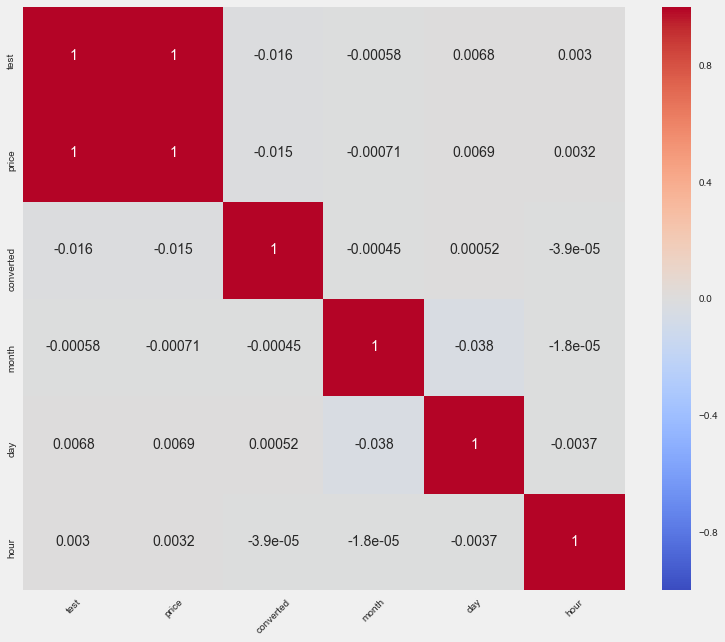

In [40]:
plt.figure(figsize=(12,10))
sns.heatmap(df_all[['test','price','converted','month','day','hour']].corr(),annot=True,cbar=True,cmap="coolwarm")
plt.xticks(rotation=45)

In [41]:
df_all = pd.merge(df_all, source.reset_index(), on='user_id')
df_all = pd.merge(df_all, device.reset_index(), on='user_id')
df_all = pd.merge(df_all, os.reset_index(), on='user_id')
df_all = pd.merge(df_all, day_of_week.reset_index(), on='user_id')


In [44]:
df_all['source_n'] = pd.factorize(df_all['source'])[0]
df_all['device_n'] = pd.factorize(df_all['device'])[0]
df_all['os_n'] = pd.factorize(df_all['operative_system'])[0]
df_all['day_of_week'] = pd.factorize(df_all['day_of_week'])[0]


In [45]:
#choose which columns to use in our dataset
cols_to_use = [u'source_n', u'device_n', u'os_n',
       u'test', u'converted'
#                , 
#         u'price',u'city', u'country', u'lat', u'long',
#        u'year', u'month', u'day', u'hour', u'source_2', u'date_2',
#        u'day_num_of_week', u'day_of_week'
              ]

In [46]:
print df_all['converted'].value_counts()
print
print "Baseline"
print len(df_all[df_all['converted']==0])*1.0*100/len(df_all)
print 100 - len(df_all[df_all['converted']==0])*1.0*100/len(df_all)

0    270597
1      5019
Name: converted, dtype: int64

Baseline
98.1789881574
1.82101184256


In [47]:
c_model = df_all[cols_to_use]
x_c = c_model.ix[:,c_model.columns != 'converted']
y_c = df_all.ix[:,df_all.columns == 'converted']

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app
/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  app.launch_new_instance()


Building model Logistic Regression


/Users/bill_mac/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy for Logistic Regression = 98.18
[[89298     0]
 [ 1656     0]]


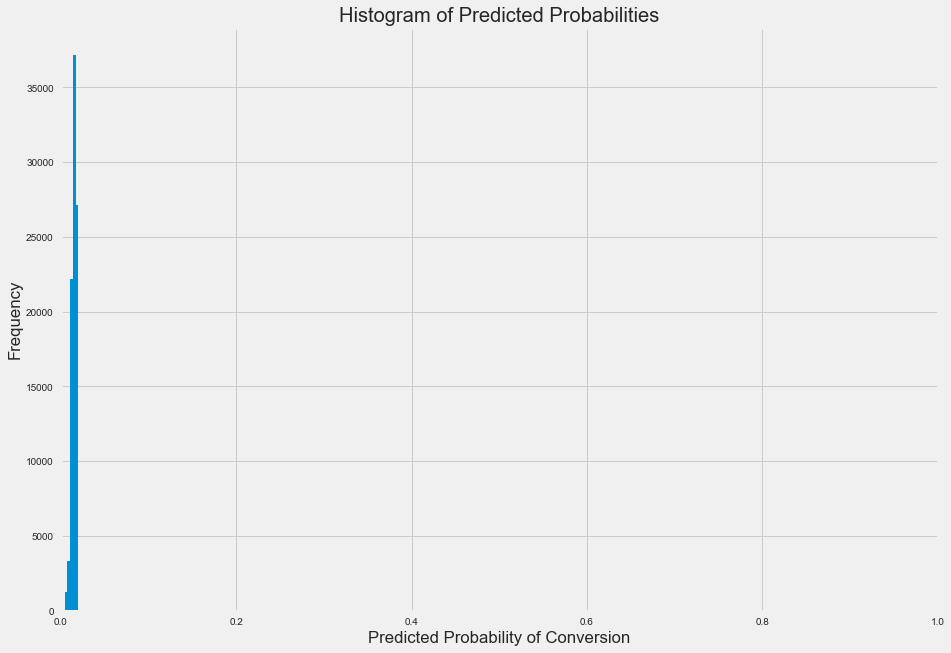

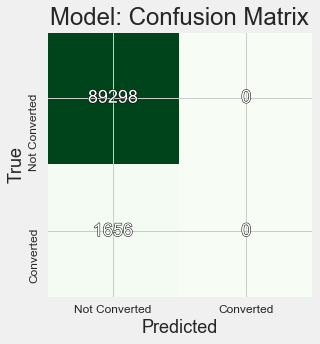

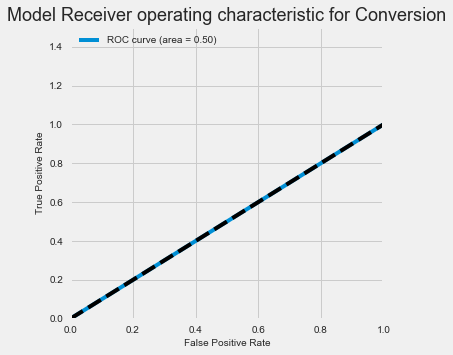

In [48]:
model_building(c_model, x_c,y_c , 'Logistic Regression')

These results are no bueno.  We're looking at a highly imbalanced dataset, but seeing these results is at least good to show that. Now we know we need to frame one way vs another.  I think I'll weigh the classifier to counter the class imbalance.  Another approach could be to downsample or upsample until you have equal class distributions.

In [49]:
# run feature selection classifier on churn model
feat_c = f_classif(x_c, y_c)
fit_c = LogisticRegression()
fit_c.fit(x_c,y_c)

# create DF to store coefficients and p-values
r2 = pd.DataFrame(data=fit_c.coef_[0],index=x_c.columns.values,columns=['coefficient'])
r2['pval'] = feat_c[1]
r2['exp_coef'] = np.exp(r2['coefficient'])
r2['sig'] = r2['pval'] <= .01

# show results
r2

,coefficient,pval,exp_coef,sig
source_n,-0.020920,2.881757e-06,0.979298,True
device_n,0.418742,3.232804e-01,1.520048,False
os_n,-0.176304,1.041383e-04,0.838363,True
test,-0.250866,2.423876e-16,0.778126,True


Alright so as expected, the source of the user, operating system, as well as if they were part of the test or control group make a difference on whether a person converted.

I binarized them so we can see how specific categories affect the conversion rate.  That is, whether windows AND macs make a difference, or just one of them. etc etc

Building model Logistic Regression
Accuracy for Logistic Regression = 98.18
[[89302     0]
 [ 1652     0]]


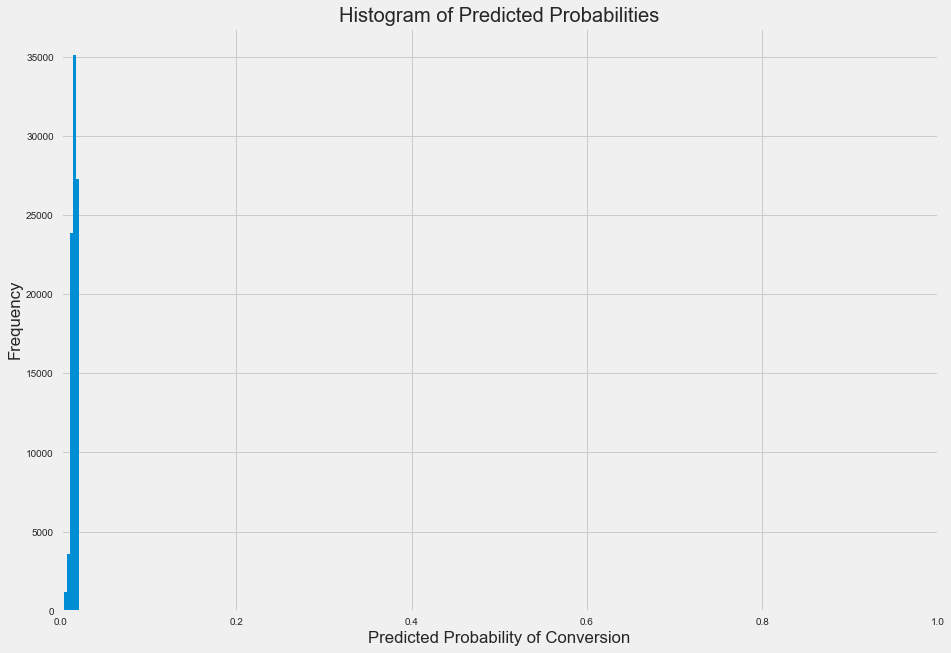

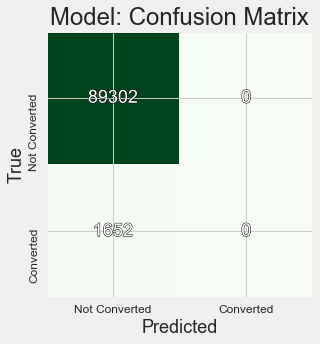

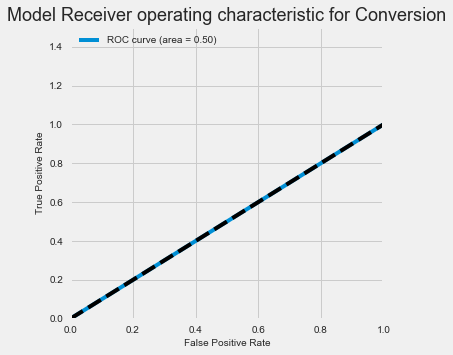

In [50]:
model_building(c_model, x_c,y_c , 'Logistic Regression')

Meh, a little better.  Let's add all feature back in, see if it helps

In [51]:
# df_all.columns
cols_to_use_full = [ 
       u'test', u'price', u'converted',
    u'month', u'day', u'hour',
       u'ads-bing', u'ads-google', u'ads-yahoo',
       u'ads_facebook', u'ads_other', u'direct_traffic', u'friend_referral',
       u'seo-bing', u'seo-google', u'seo-other', u'seo-yahoo', u'seo_facebook',
       u'mobile', u'web', u'android', u'iOS', u'linux', u'mac', u'other',
       u'windows', u'Friday', u'Monday', u'Saturday', u'Sunday', u'Thursday',
       u'Tuesday', u'Wednesday']
c_model = df_all[cols_to_use_full]
x_c = c_model.ix[:,c_model.columns != 'converted']
y_c = df_all.ix[:,df_all.columns == 'converted']

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


Building model Logistic Regression
Accuracy for Logistic Regression = 98.24
[[89357     0]
 [ 1597     0]]


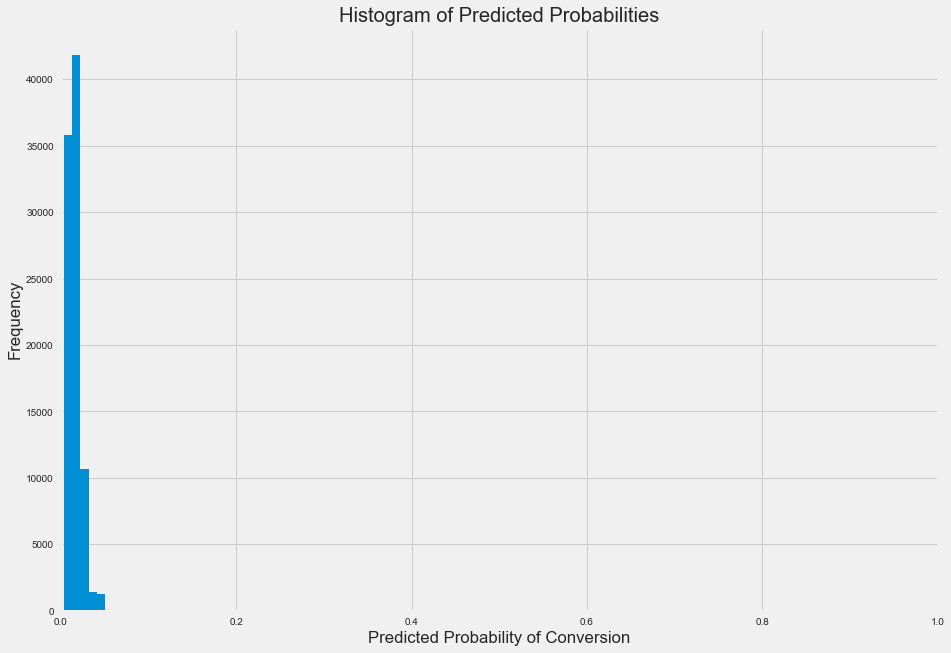

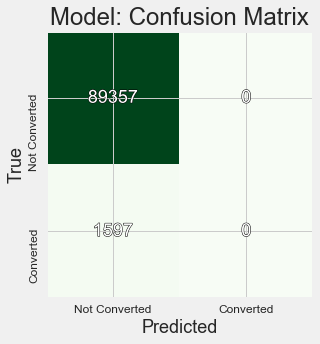

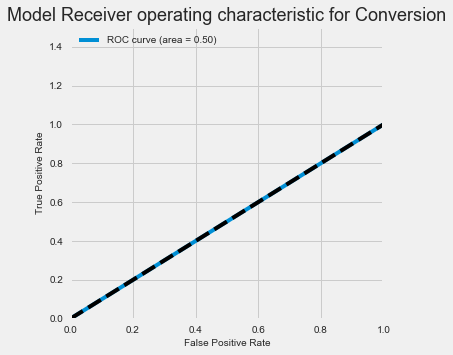

In [52]:
model_building(c_model, x_c,y_c , 'Logistic Regression')

In [53]:
# run feature selection classifier on churn model
feat_c = f_classif(x_c, y_c)
fit_c = LogisticRegression()
fit_c.fit(x_c,y_c)

# create DF to store coefficients and p-values
r2 = pd.DataFrame(data=fit_c.coef_[0],index=x_c.columns.values,columns=['coefficient'])
r2['pval'] = feat_c[1]
r2['exp_coef'] = np.exp(r2['coefficient'])
r2['sig'] = r2['pval'] <= .01

# show results
r2

,coefficient,pval,exp_coef,sig
test,-0.034379,2.423876e-16,0.966205,True
price,-0.010903,6.596822e-16,0.989156,True
month,-0.009733,8.134791e-01,0.990314,False
day,0.000461,7.842378e-01,1.000461,False
hour,0.000097,9.836527e-01,1.000097,False
ads-bing,-0.541039,8.184527e-12,0.582143,True
ads-google,0.043469,2.741345e-09,1.044427,True
ads-yahoo,-0.329791,2.662646e-02,0.719074,False
ads_facebook,0.034513,1.279097e-07,1.035115,True
ads_other,-0.353235,1.136216e-06,0.702412,True


Couple quick notes - It looks like the day of the week does not play a significant role on conversion.  One thing we could try next would be to create a weekend vs weekday feature, or an hourly split like daytime/nighttime or 9-5 vs other.

Continuing from the bottom up, it looks like all operating systems play a role in converting, but with mac being the only positive force on the likelihood of conversion (as shown by the exponentiated coefficient > 1, so mac increases the odds ratio).  Conversely, using linux or the 'other' operating system negatively affects the likelihood of conversion.

In terms of the device used, mobile vs web - neither are significant factors.  This is most likely because the operating systems that are significant are a subset. So while the fact that you use a mobile device or the web doesn't matter, but the kind of computer and operating systme that is on that mobile or web device does matter.

<u>Source</u>
The results above reinforce the graphs we saw earlier that friend referrals, direct traffic, and ads coming from facebook/google/bing/other matter. More importantly, friend referrals have the greatest positive effect on the likelihood of conversion, followed by the slightly positive coefficients of facebook and google ads.  Finally, we see that direct traffic and users coming from ads placed on bing have a lower likelihood of conversion


However, we can still learn some interesting things from the significance of the coefficients. We can see that ads, direct traffic, and friend referrals have significant coefficients, with generally positive effects on conversion rate (as shown by the exponentiated coefficient > 1, implying these variables increase the odds ratio) for ads, and a very positive effect for friend referral. Note that for the source variable, the base case is ads-bing and all numbers are relative to that. The base cases for device and OS are mobile and Android, respectively. We also see that Windows, iOS, and Mac users have stronger conversion rates, while Linux and other users do not (compared to Android). These are useful insights, and after running a few more models, we will discuss their implications in terms of actionable insights

#### Random Forest
* Let's give an RF model a try. Random Forests are good because you can usually optimize the algorithm pretty quickly.  It's also pretty good with outliers, and finding important variables.  
* We're going to use the RF to predict conversion and then use it's partial dependence plots and variable feature importances to see how our model go information from the variables and which variables are the best for predicting.
* Also, we're able to build and see the tree which we can then use to find our most obvious user segments.  


#### Shuffle, Split, CV

Create test/training set with a standard 66% split (if the data were too small, I would cross-validate) and
then build the forest with standard values for the 3 most important parameters (100 trees, trees as large as
possible, 3 random variables selected at each split)

In [55]:
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.patheffects as path_effects
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc


def measure_performance(X, y, clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred = clf.predict(X)   
    if show_accuracy:
         print "F1:{0:.3f}".format(metrics.f1_score(y, y_pred)),"\n"
    if show_classification_report:
        print "Classification report"
        print metrics.classification_report(y, y_pred),"\n"    
    if show_confusion_matrix:
        print "Confusion matrix"
        print metrics.confusion_matrix(y, y_pred),"\n"

In [69]:
print ("Baseline Accuracy: %r "%(1-df_all.converted.mean()))

Baseline Accuracy: 0.98178988157436431 


In [57]:
c_model = df_all[cols_to_use_full]
X = c_model.ix[:,c_model.columns != 'converted']
y = df_all.iloc[:,df_all.columns=='converted']

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


Building model Random Forest


/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Features importance:                    values
index                    
hour             0.563613
day              0.233636
month            0.045167
Sunday           0.009682
Friday           0.009402
Saturday         0.008860
Thursday         0.008543
Tuesday          0.007547
seo-google       0.007254
ads_facebook     0.006934
seo_facebook     0.006926
ads-google       0.006893
Wednesday        0.006841
price            0.006450
Monday           0.005774
test             0.005740
ads_other        0.005485
friend_referral  0.005218
direct_traffic   0.004796
ads-yahoo        0.004657
seo-other        0.004620
other            0.004312
android          0.004269
ads-bing         0.004018
iOS              0.003839
mac              0.003818
seo-yahoo        0.003439
windows          0.003429
mobile           0.002632
seo-bing         0.002567
web              0.002001
linux            0.001637
Accuracy for Random Forest = 97.84
[[88967   305]
 [ 1662    20]]


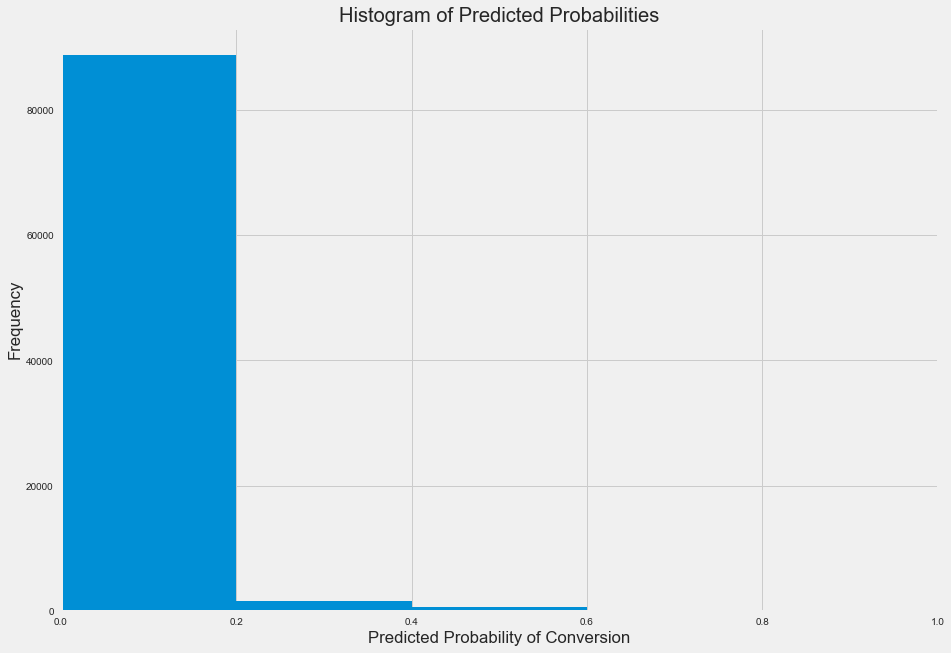

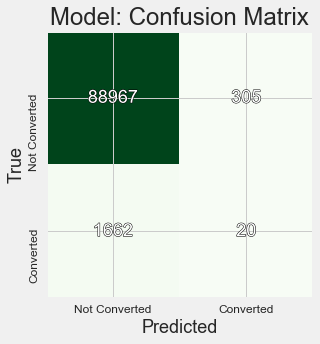

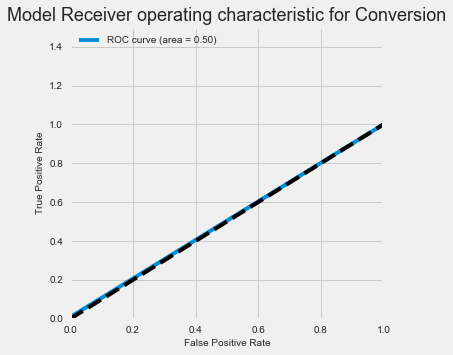

In [58]:
model_building(c_model, x_c,y_c , 'Random Forest')

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20)

In [60]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
# X_test = clf.transform(X_test)
# measure_performance(X_test_fs, y_test, clf, show_confusion_matrix=False, show_classification_report=False)
measure_performance(X_test, y_test, clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True)

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


F1:0.014 

Classification report
             precision    recall  f1-score   support

          0       0.98      1.00      0.99     54196
          1       0.04      0.01      0.01       928

avg / total       0.97      0.98      0.97     55124


Confusion matrix
[[54024   172]
 [  920     8]] 



Interesting, it looks like the out of the box randomforest classifier benchmark is better than the one I used to account for weight imbalance.  Something to look into later

In [61]:
# These represent the y-intercept and coefficients for all the variables in the Random Forest.
def model_stats(model = RandomForestClassifier(), X_train = X_train, y_train = y_train, y_test = y_test, X_test = X_test):


    # 10-fold cross-validation for Random Forest to find the CV score
    mdl = model.fit(X_train, y_train)
    scores = cross_val_score(mdl, X_train, y_train, cv=10, scoring= 'accuracy')
    print("Mean CV Accuracy for Model: %r "% scores.mean())
    print()
    logit = model.predict(X_test)
    confusion = metrics.confusion_matrix(y_test, logit)
    print("Confusion Matrix for Model")
    print (confusion)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    # histogram of predicted probabilities of people leaving the company 
    plt.hist(y_pred_prob, bins=5)
    plt.xlim(0, 1)
    plt.title('Histogram of Predicted Probabilities')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    cm = confusion_matrix(y_test, logit)


    plot_confusion_matrix(cm, title='Model: Confusion Matrix', \
                          labels=['Stayed', 'Left'], cmap=plt.cm.Greens) 
    # Roc_curve for Our Model
    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    # For class 1, find the area under the curve
    FPR[1], TPR[1], _ = roc_curve(y_test, logit)
    ROC_AUC[1] = auc(FPR[1], TPR[1])

    # Plot of a ROC curve for class 1 (Converted)
    plt.figure(figsize=[5,5])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0, 1])
    plt.ylim([0, 1.5])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title('Model Receiver operating characteristic', fontsize=18)
    plt.legend(loc="upper left")
    plt.show()

Mean CV Accuracy for Model: 0.97786767731113611 
()
Confusion Matrix for Model
[[54005   191]
 [  920     8]]


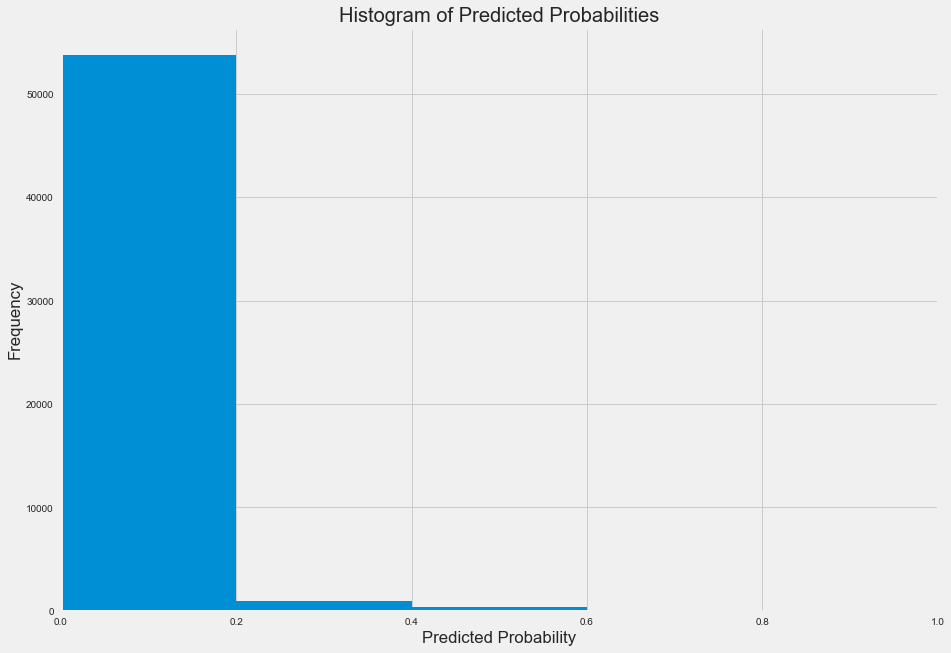

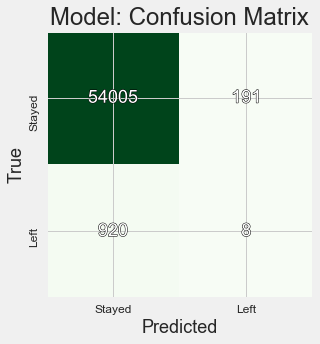

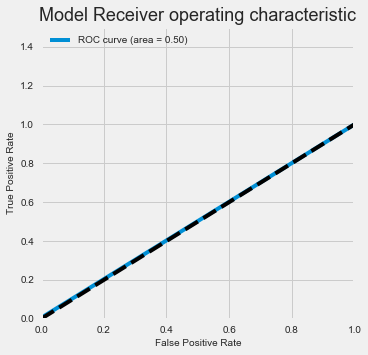

In [62]:
model_stats(model = RandomForestClassifier(), X_train = X_train, y_train = y_train.values.ravel(), y_test = y_test, X_test = X_test)

Since we started from a 98% accuracy (that’s the case if we classified everything as “non converted”), our 97% is not great

If we cared about the very best possible accuracy or specifically minimizing false positive/false negative,
we would also use ROCR and find the best cut-off point. If I had a bit more time, I'd most likely grid search and find which model gives us the best ROC curve.

Since in this case that doesn’t appear to be particularly relevant, we are fine with the default 0.5 cutoff value used internally by the random forest to make the prediction. 

Let's check out the insights we can find from this model

### Random Forest with Weighted Classes

In [63]:
clf = RandomForestClassifier(class_weight = {1:.7, 0:.3}, oob_score = True)
clf.fit(X_train, y_train)
# X_test = clf.transform(X_test)
# measure_performance(X_test_fs, y_test, clf, show_confusion_matrix=False, show_classification_report=False)
measure_performance(X_test, y_test, clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True)

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/Users/bill_mac/.local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/bill_mac/.local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


F1:0.012 

Classification report
             precision    recall  f1-score   support

          0       0.98      0.99      0.99     54196
          1       0.02      0.01      0.01       928

avg / total       0.97      0.98      0.97     55124


Confusion matrix
[[53848   348]
 [  920     8]] 



### How long should we run the test for / could we end the test early


Let's check the results of the binomial test at each date of the test we're running

In [106]:
timestamps = df_all.day_num_of_week.unique()
binom_test(x=revenue_simple[True].iloc[1],n=revenue_simple[False].iloc[1],p=((revenue_simple['Conversion_Rate'].iloc[0])*(revenue_simple['Price'].iloc[0]/revenue_simple['Price'].iloc[1])))

In [110]:
days=[0]
num=[0]
pval=[0]
for j,i in enumerate(timestamps[1:]):
    dfa = df_all.loc[df_all['day_num_of_week']<=i]
    days.append(j)
    num.append(len(dfa))
    contingency_table=pd.crosstab(dfa.test ==True, dfa.converted ==True)
    ct = pd.DataFrame(contingency_table).reset_index()
    ct['Conversion_Rate']=ct[True]/ct[False]
    ct['Price']=[39,59]
    ct['Expected_Revenue']=ct.Conversion_Rate*ct.Price
    pvali = binom_test(x=ct[True].iloc[1],n=ct[False].iloc[1],p=((revenue_simple['Conversion_Rate'].iloc[0])*(revenue_simple['Price'].iloc[0]/revenue_simple['Price'].iloc[1])))
    strfisher = str(pvali)
    pval.append(pvali)

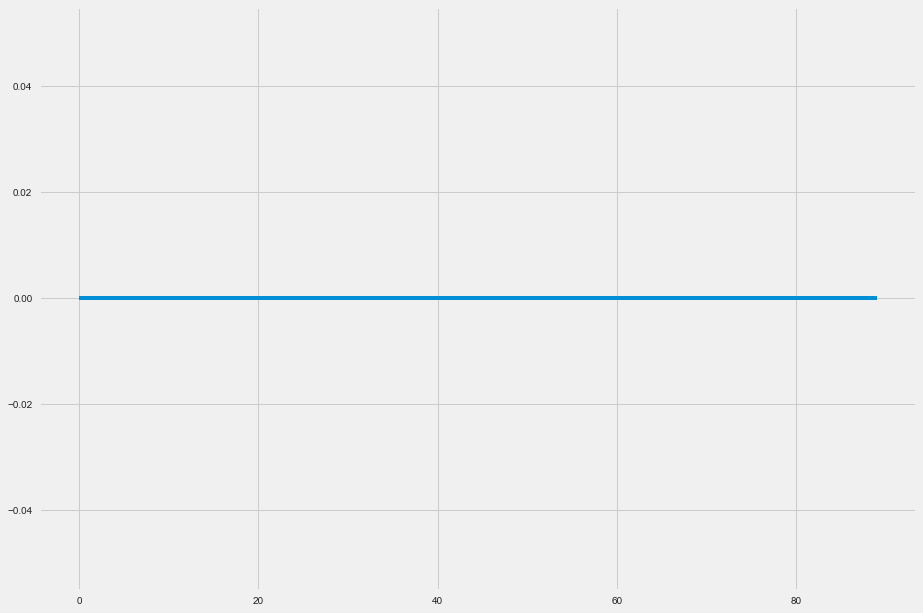

In [111]:
plt.plot(days[1:],pval[1:])
plt.show()

 ^ Need to test this again, does not seem to be working

Even though our first attempt isn't working, we can figure out how long we need to keep the test running by finding how many users we need to find a statistically significant sample.

Let's think about how we can figure this out. If we want to know response rate we should measure the difference between our two groups.

We want to find the miminum sample size need for our results to be significant, so we need to assume a few things.

First, our response rates for the two samples are we observed in our data. That is 0.020175 for our test group and  0.015667 for our control group, and .018210 overall.

Let's also assume we have a 2/3 and 1/3 distribution across test and control groups.

Alright, so let's lay out the z-test equation which is 

$$ Z=\dfrac{(\hat{p}_1-\hat{p}_2)-0}{\sqrt{\hat{p}(1-\hat{p})\left(\dfrac{1}{n_1}+\dfrac{1}{n_2}\right)}} $$

using our information above, this equation becomes:

$$ Z=\dfrac{0.020175-0.015667}{\sqrt{.018210(1-.018210)\left(\dfrac{1}{n_1}+\dfrac{2}{n_1}\right)}} $$

solving slightly further it becomes:

$$ Z=\dfrac{.0045}{\sqrt{.01787\left(\dfrac{3}{n_1}\right)}} $$

Great so now we have our equation looking good, but what level of significance do we want to see?  By setting our Z on the left side, we'll then be able to solve for n and ultimately find out how many samples are needed for that statistical level.

We want 1%, so the z-score for that is 2.576

$$ 2.576=\dfrac{.0045}{\sqrt{.01787\left(\dfrac{3}{n_1}\right)}} $$

$$ 2.576 * \sqrt{.01787\left(\dfrac{3}{n_1}\right)} = .0045 $$

$$ \sqrt{.01787\left(\dfrac{3}{n_1}\right)} = 0.001747 $$

$$ .01787\dfrac{3}{n_1} = 0.000003052 $$

$$ 0.00017078953 = \dfrac{3}{n_1} $$

$$ n_1 = 17565 $$

Alright, that was fun!

It looks like we need 17.5k people in group one and therefore around another 8-9 thousand in group 2 for at least 27000 people.  

We have a ton of samples in our dataset, 275k. That's an order of magnitude greater than what we need.  Our users per day range between 1500-6000 users a day, so a few weeks of the experiment should yield plenty of data for us
